In [1]:
from typing import Dict, List, Union, Optional

from pydantic import BaseModel, Field, ValidationError, validator


class Record(BaseModel):
    date: str
    signal: float
    sv_warning_min: float
    sv_warning_max: float
    sv_alarm_min: float
    sv_alarm_max: float


class Pack(BaseModel):
    charts: List[Dict[str, List]]


class Result(BaseModel):
    signal_id: str
    data: List[Record]


In [2]:
import json
from typing import List

import requests
from pydantic.tools import parse_obj_as


In [3]:
def get_data(start_time, end_time, ids) -> List[Result]:
    final_url = 'https://evraz-api.kovalev.team/api/chart_values?'
    final_url += '&'.join([f'signal_kind_ids[]={i}' for i in ids])
    final_url += f'&start_time={start_time}&end_time={end_time}&include_setpoints=1'
    # print(final_url)
    response = requests.get(final_url)
    res = parse_obj_as(Pack, response.json())
    result = []
    for i in ids:
        result.append(Result(
            signal_id=i,
            data=[
                Record(
                    date=res.charts[0][i][rec][0],
                    signal=res.charts[0][i][rec][1],
                    sv_warning_min=res.charts[0][i][rec][2],
                    sv_warning_max=res.charts[0][i][rec][3],
                    sv_alarm_min=res.charts[0][i][rec][4],
                    sv_alarm_max=res.charts[0][i][rec][5],
                ) for rec in range(len(res.charts[0][i]))
            ]
        ))

    return result


In [60]:
raw_train_data = get_data('2023-02-16', '2023-02-17', ['2859'])

In [5]:
from darts import TimeSeries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [6]:
def result_to_timeseries(data: Result):
    # for rec in data.data:
        # print(rec)

    temp = {}
    try:
        temp = {
            'date': [datetime.fromisoformat(i.date) for i in data.data],
            'value': [i.signal for i in data.data]
        }
    except KeyError:
        print('Неверно задан тип элемента.')
    
    df = pd.DataFrame.from_dict(temp)

    # print(df.date.min(), df.date.max())
    delta = df.date.max() - df.date.min()
    all_datetimes = [df.date.min() + timedelta(minutes=i)
          for i in range(int(delta.total_seconds()/60) + 1)]
    # print(len(all_datetimes), len(df))
    # print(datetime.fromisoformat(df.iloc[-1].date) -
    #       datetime.fromisoformat(df.iloc[0].date))

    # missing_data = [[i, 0] for i in set(df.date.to_list()) ^ set(all_datetimes)]
    # print(missing_data)
    # print(len(missing_data))
    # mddf = pd.DataFrame(missing_data, columns=['date', 'value'])
    # mddf.fillna(0, inplace=True)
    # dff = pd.concat([df, mddf], keys=['date', 'value'])
    df['date'] = pd.to_datetime(df.date).dt.tz_localize(None)
    df['date'] = df['date'].dt.floor('Min')

    # for i in dff['date']:
    #     if i == np.datetime64('NaT'):
    #         print(i)

    # print(df)

    # dff.date = pd.to_datetime(dff.date, format='%Y-%m-%dT%H:%M:%S+03:00')

    res = TimeSeries.from_dataframe(
        df, time_col='date', value_cols='value', fill_missing_dates=True, freq='min')
    # print(res.values)
    return res


In [7]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rho_risk
from darts.metrics import mae, mape, mse
from darts.models import RNNModel
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.timeseries_generation import datetime_attribute_timeseries


d:\Repos\evraz-predict\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Repos\evraz-predict\env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'D:\Repos\evraz-predict\env\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [47]:
def prepare_ts(ts: TimeSeries,
                transformer: Scaler,
                split_date: str = '2023-02-16T00:18:00.000',
                future_days: int = 10) -> tuple:
    # Создание тренировочного и валидационного датасета
    # train, val = ts.split_after(pd.Timestamp(split_date))
    train, val = ts[:-1000], ts[-1000:]

    # Нормализация
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    # series_transformed = transformer.transform(ts)

    # Создание временных ковариантов
    minutes_series = datetime_attribute_timeseries(
        pd.date_range(start=ts.start_time(), freq=ts.freq_str,  # type: ignore
                      periods=len(ts)+future_days*1440),
        attribute="minute",
        one_hot=False,
    )
    second_series = datetime_attribute_timeseries(
        minutes_series, attribute="second", one_hot=True
    )

    # covariates = hours_series.stack(minutes_series)
    covariates = minutes_series.stack(second_series)

    covariates = Scaler().fit_transform(covariates)

    cov_train, cov_val = covariates[:-1000], covariates[-1000:]

    return train_transformed, val_transformed, cov_train, cov_val


In [9]:
transformer = Scaler()

In [61]:
data = result_to_timeseries(raw_train_data[0])

In [11]:
future_days = 1

In [62]:
train_data, val_data, covar_train_data, covar_val_data = prepare_ts(
    data,
    transformer,
    split_date='2023-02-16T22:40:25.000',
    future_days=future_days)


In [63]:
print(len(covar_train_data)+len(covar_val_data))
print(covar_val_data)
# print(covar_train_data)

2880
<TimeSeries (DataArray) (time: 1000, component: 61, sample: 1)>
array([[[0.33898305],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.3559322 ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.37288136],
        [0.        ],
        [0.        ],
        ...,
...
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.98305085],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[1.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-02-17T07:20:00 ... 2023-02-17T23:59:00
  * component  (component) object 'minute' 'second_1' ... 'second_60'
Dimensions with

In [64]:
# Создание временных ковариантов
minutes_series = datetime_attribute_timeseries(
    pd.date_range(start=data.start_time(), freq=data.freq_str,  # type: ignore
                  periods=len(data)+future_days*1440),
    attribute="minute",
    one_hot=False,
)
second_series = datetime_attribute_timeseries(
    minutes_series, attribute="second", one_hot=True
)

# covariates = hours_series.stack(minutes_series)
covariates = minutes_series.stack(second_series)

covariates = Scaler().fit_transform(covariates)


In [65]:
# covariates = Scaler().fit_transform(covariates)

In [70]:
rnn_model = RNNModel(
    model="LSTM",
    n_rnn_layers=3,
    hidden_dim=30,
    dropout=0.07,
    batch_size=8,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Evraz_RNN",
    random_state=42,
    training_length=len(val_data)-1,
    input_chunk_length=32,
    output_chunk_length=len(val_data)+future_days*1440,
    force_reset=True,
    save_checkpoints=True,
    # pl_trainer_kwargs={
    #     "accelerator": "gpu",
    #     "devices": [1]
    # },
)


In [45]:
import torch
# torch.zeros(1).cuda()
print(torch.cuda.is_available())
print(torch.cuda.device_count())


False
0


In [71]:
rnn_model.fit(
    train_data,
    future_covariates=covar_train_data,
    val_series=val_data,
    val_future_covariates=covar_val_data,
    verbose=True,
    num_loader_workers=8
)

ValueError: The train dataset does not contain even one training sample. This is likely due to the provided training series being too short. This model expect series of length at least 1000.


ValueError: The train dataset does not contain even one training sample. This is likely due to the provided training series being too short. This model expect series of length at least 1000.

In [32]:
best_model = RNNModel.load_from_checkpoint(
    model_name="Evraz_RNN", best=True)


In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt

In [76]:
best_model = RNNModel.load("first_model")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


AttributeError: 'DataFrame' object has no attribute 'width'

<Figure size 800x500 with 0 Axes>

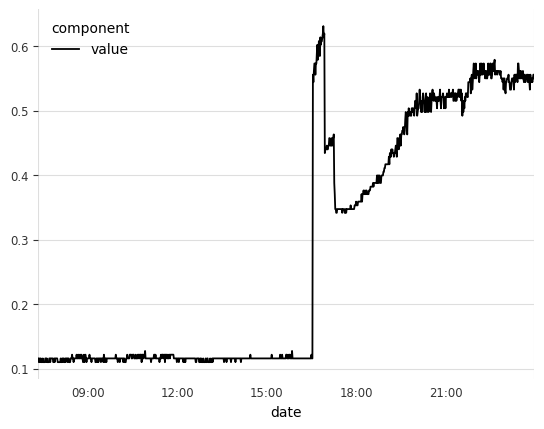

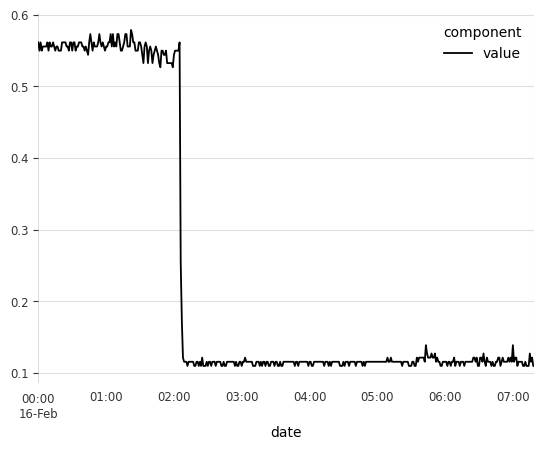

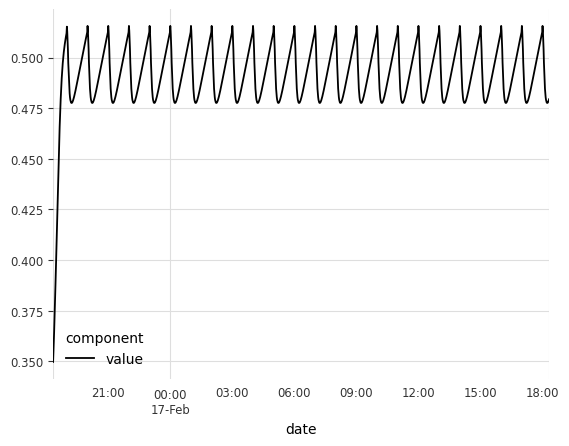

In [78]:
pred_series = best_model.predict(n=len(data),
                            future_covariates=covariates)
pred_series = transformer.inverse_transform(
    pred_series).pd_dataframe()
plt.figure(figsize=(8, 5))
val_data.plot(label="Ожидание")
train_data.plot(label="График")
pred_series.plot(label="Предсказание")
plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_data)))
plt.legend()


In [93]:
import json

old_dict = pred_series.to_dict()
new_dict = {}
for key, value in old_dict['value'].items():
    # print(key)
    new_dict[str(key.isoformat())] = value
print(new_dict)
# print(json.dumps(new_dict, indent=4, default=str))


{'2023-02-16 18:20:00': 0.3497422250032254, '2023-02-16 18:21:00': 0.35429708855702446, '2023-02-16 18:22:00': 0.35911009378584624, '2023-02-16 18:23:00': 0.36461951932019127, '2023-02-16 18:24:00': 0.37017301182169277, '2023-02-16 18:25:00': 0.37603466057369034, '2023-02-16 18:26:00': 0.3822438964470473, '2023-02-16 18:27:00': 0.38858228009086243, '2023-02-16 18:28:00': 0.3951466037175443, '2023-02-16 18:29:00': 0.4018507750156974, '2023-02-16 18:30:00': 0.4086351422643062, '2023-02-16 18:31:00': 0.41548681210857663, '2023-02-16 18:32:00': 0.42233754463229817, '2023-02-16 18:33:00': 0.42913088535236626, '2023-02-16 18:34:00': 0.43581247732790046, '2023-02-16 18:35:00': 0.44232078048328655, '2023-02-16 18:36:00': 0.44860154397912955, '2023-02-16 18:37:00': 0.4546062495715148, '2023-02-16 18:38:00': 0.46029268878293667, '2023-02-16 18:39:00': 0.46562868561743753, '2023-02-16 18:40:00': 0.4705917592561207, '2023-02-16 18:41:00': 0.47516972031908455, '2023-02-16 18:42:00': 0.4793606031006

In [35]:
best_model.save('first_model')